Largely based on `cifar10_cnn.py` from the Keras examples.

This classifies the images from the CIFAR 10 small image data set using a convolutional neural network (CNN).

In [24]:
%matplotlib inline

from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import os.path

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

These are the 10 categories from the CIFAR 10 data set:

In [3]:
category = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

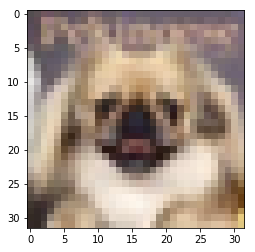

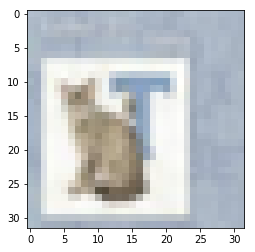

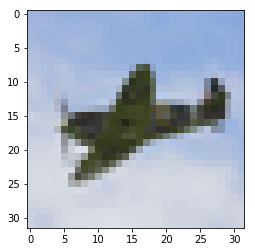

In [30]:
i_s = np.random.randint(0, len(X_train), size=3)

for i in i_s:
    true_label = int(y_train[i])
    plt.imshow(X_train[i]); plt.show()
    display(HTML('{} {}'.format(true_label, category[true_label])))
    

In [5]:
from keras.utils import np_utils

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [6]:
print(Y_train[i_s])

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


In [7]:
model_fn = 'cifar10_model.h5'
if os.path.exists(model_fn):
    model = load_model(model_fn)
else:
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:], activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(category), activation='softmax'))

    # Fails to converge using RMSprop, see https://github.com/fchollet/keras/issues/4897, so use
    # Adam instead.
    optimizer = 'adam'

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    model.summary()

    model.fit(X_train, Y_train,
              batch_size=32,
              epochs=50,
              validation_data=(X_test, Y_test),
              shuffle=True,
              verbose=2)
    model.save(model_fn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

Here are some example predictions from the test set:

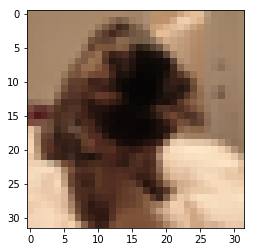

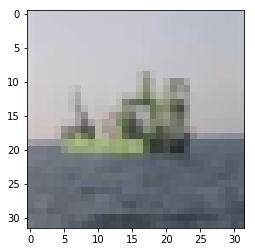

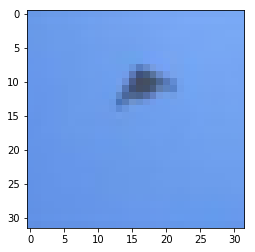

In [32]:
test_i_s = np.random.randint(0, len(X_test), size=3)

for X, pred, true_label in zip(X_test[test_i_s], model.predict_classes(X_test[test_i_s], verbose=False), y_test[test_i_s]):
    true_label = int(true_label)
    plt.imshow(X)
    plt.show()
    
    color = "green" if pred == true_label else "red"
    
    display(HTML(
        '<span style="color: {}">{} {}</span><br/>{} {}'.format(
            color,
            pred, category[pred],
            true_label, category[true_label]
        )
    ))